In [1]:
import torch
torch.__version__

'1.7.1'

In [2]:
#!pip install torch==1.9.0
!pip install torchvision==0.10.0

     |████████████████████████████████| 22.1 MB 21.4 MB/s            
     |████████████████████████████████| 831.4 MB 5.3 kB/s             
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.2
    Uninstalling torchvision-0.8.2:
      Successfully uninstalled torchvision-0.8.2


In [14]:
#!python main.py -ms energy -ml 5 -ma 1 -mc png
!python main.py

building network of steps: 
[4, 4, 4, 4, 4] 20
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 32 outChannels 6		|

|		inScales 3 outScales 3 inChannels 38 outChannels 6		|

|		inScales 3 outScales 3 inChannels 44 outChannels 6		|

|		inScales 3 outScales 3 inChannels 50 outChannels 6		|

224
 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 56 outChannels 6		|

|		inScales 3 outScales 3 inChannels 62 outChannels 6		|

|		inScales 3 outScales 3 inChannels 68 outChannels 6		|

|		inScales 3 outScales 2 inChannels 74 outChannels 6		|
|		Transition layer inserted! (max), inChannels 80, outChannels 40	|

160
 ********************** Block 3  **********************
|		inScales 2 outScales 2 inChannels 40 outChannels 6		|

|		inScales 2 outScales 2 inChannels 46 outChannels 6		|

|		inScales 2 outScales 2 inChannels 52 outChannels 6		|

|		inScales 2 outScales 2 inChannels 58 outChannels 6		|

256
 *******

In [6]:
#pip install fastai 1.0.61 nvidia-ml-py3

In [8]:
#pip install gdown
import os
os.chdir('../')

In [9]:
!ls

complexity	Flops			mood.ipynb	   README.md
compressed.png	mahalanobis_parameters	msd_args.py	   trained_model
data		main.py			msd_dataloader.py  utils
figs		models			__pycache__


In [5]:
import gdown

url = 'https://drive.google.com/uc?id=1ZB6wM9KPenTP-dzLutbMgn4wngDfatdf'
output = 'places365.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ZB6wM9KPenTP-dzLutbMgn4wngDfatdf
To: /home/ec2-user/SageMaker/MOOD/data/places365.zip
100%|██████████| 8.83G/8.83G [04:24<00:00, 33.4MB/s]


'places365.zip'

In [15]:
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from utils.dataloader import get_dataloader
from utils.MOOD import get_ood_score, sample_estimator
from utils.MOOD import auroc, fpr95
#import argparse
from msd_args import arg_parser
import models
from msd_dataloader import msd_get_dataloaders

if 1: #load and test model

    mood_args, _ = arg_parser.parse_known_args()
    mood_args.grFactor = list(map(int, mood_args.grFactor.split('-')))
    mood_args.bnFactor = list(map(int, mood_args.bnFactor.split('-')))
    mood_args.nScales = len(mood_args.grFactor)
    
    if mood_args.use_valid:
        mood_args.splits = ['train', 'val', 'test']
    else:
        mood_args.splits = ['train', 'val']
    mood_args.data = mood_args.id
    if mood_args.data == 'cifar10':
        mood_args.num_classes = 10
    elif mood_args.data == 'cifar100':
        mood_args.num_classes = 100
    else:
        print('dataset not support!')
    
    model = getattr(models, mood_args.arch)(mood_args)
    model = torch.nn.DataParallel(model).cuda()
    
    criterion = nn.CrossEntropyLoss().cuda()

    cudnn.benchmark = True
    train_loader, val_loader, test_loader = msd_get_dataloaders(mood_args)
    print("*************************************")
    print(mood_args.use_valid, len(train_loader), len(val_loader))
    print("*************************************")
    
    model.load_state_dict(torch.load(mood_args.file)['state_dict'])
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    model.eval()


if mood_args.id == 'cifar10':
    MEAN=[0.4914, 0.4824, 0.4467]
    STD=[0.2471, 0.2435, 0.2616]
    NM = [MEAN,STD]
elif mood_args.id == 'cifar100':
    MEAN=[0.5071, 0.4867, 0.4408]
    STD=[0.2675, 0.2565, 0.2761]
    NM = [MEAN,STD]
else:
    print('wrong indistribution dataset! use cifar10 or cifar100!')
    
normalizer = transforms.Normalize(mean=MEAN, std=STD)
print('calculating ood scores and complexity takes long time')
print('process ',mood_args.id)

dataloader = get_dataloader(mood_args.id, normalizer, mood_args.bs)


building network of steps: 
[4, 4, 4, 4, 4] 20
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 32 outChannels 6		|

|		inScales 3 outScales 3 inChannels 38 outChannels 6		|

|		inScales 3 outScales 3 inChannels 44 outChannels 6		|

|		inScales 3 outScales 3 inChannels 50 outChannels 6		|

224
 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 56 outChannels 6		|

|		inScales 3 outScales 3 inChannels 62 outChannels 6		|

|		inScales 3 outScales 3 inChannels 68 outChannels 6		|

|		inScales 3 outScales 2 inChannels 74 outChannels 6		|
|		Transition layer inserted! (max), inChannels 80, outChannels 40	|

160
 ********************** Block 3  **********************
|		inScales 2 outScales 2 inChannels 40 outChannels 6		|

|		inScales 2 outScales 2 inChannels 46 outChannels 6		|

|		inScales 2 outScales 2 inChannels 52 outChannels 6		|

|		inScales 2 outScales 2 inChannels 58 outChannels 6		|

256
 *******

In [24]:
i_score, i_adjusted_score, i_complexity = get_ood_score(data_name=mood_args.id,
                           model=model,
                           L=mood_args.layer,
                           dataloader=dataloader,
                           score_type=mood_args.score,
                           threshold=mood_args.threshold,
                           NM=NM,
                           adjusted_mode=0,   
                           mean=None,
                           cal_complexity=False
                           )
mean=[]
for i in range(mood_args.layer):
    mean.append( np.mean(i_score[i]) )

i_score, i_adjusted_score, i_complexity = get_ood_score(data_name=mood_args.id,
                           model=model,
                           L=mood_args.layer,
                           dataloader=dataloader,
                           score_type=mood_args.score,
                           threshold=mood_args.threshold,
                           NM=NM,
                           adjusted_mode=mood_args.adjusted,
                           mean=mean,
                           cal_complexity=False
                           )
auroc_base = []
fpr95_base = []
auroc_mood = []
fpr95_mood = []
auroc_for_barplot = []
complexity_for_arplot = []
for o_name in mood_args.od:
    print('process ',o_name)
    dataloader = get_dataloader(o_name, normalizer, mood_args.bs)
    o_score, o_adjusted_score, o_complexity = get_ood_score(data_name=o_name,
                           model=model,
                           L=mood_args.layer,
                           dataloader=dataloader,
                           score_type=mood_args.score,
                           threshold=mood_args.threshold,
                           NM=NM,
                           adjusted_mode=mood_args.adjusted,
                           mean=mean,
                           cal_complexity=False
                           )
    print('size ' + str(o_complexity.size))
    print('min ' + str(np.min(o_complexity)))
    print('max ' + str(np.max(o_complexity)))
    print('mean ' + str(np.mean(o_complexity)))

    auroc_base.append(auroc(i_score[-1], o_score[-1]))
    fpr95_base.append(fpr95(i_score[-1], o_score[-1]))
    auroc_mood.append(auroc(i_adjusted_score, o_adjusted_score))
    fpr95_mood.append(fpr95(i_adjusted_score, o_adjusted_score))
    auroc_for_barplot.append([auroc(i_score[i], o_score[i]) for i in range(mood_args.layer)])
    complexity_for_arplot.append(o_complexity)

print('********** auroc result ',mood_args.id,' with ',mood_args.score,' **********')
print('                         auroc                  fpr95    ')
print('OOD dataset      exit@last    MOOD      exit@last    MOOD')
for i in range(len(mood_args.od)):
    data_name=mood_args.od[i]
    data_name = data_name + ' '*(17-len(data_name))
    print(data_name,"%.4f"%auroc_base[i],'   ',"%.4f"%auroc_mood[i],'    ',"%.4f"%fpr95_base[i],'   ',"%.4f"%fpr95_mood[i])
data_name = 'average'
data_name = data_name + ' '*(17-len(data_name))
print(data_name,"%.4f"%np.mean(auroc_base),'   ',"%.4f"%np.mean(auroc_mood),'    ',"%.4f"%np.mean(fpr95_base),'   ',"%.4f"%np.mean(fpr95_mood))


if mood_args.score == 'energy' and mood_args.adjusted == 1 :
    flops = np.array([26621540, 51598536, 68873004, 88417936, 105102580])
    auroc_score = np.array(auroc_for_barplot)
    S=20
    selected_datasets = mood_args.od
    selected_score = np.zeros_like(auroc_score)
    for k, complexity in enumerate(complexity_for_arplot):
        for i in range(mood_args.layer):
            index = (mood_args.threshold[i]<complexity) * (complexity<=mood_args.threshold[i+1])
            selected_score[k,i] = np.sum(index)/complexity.shape[0]
    
    Flops = np.zeros([len(mood_args.od)])
    for i in range(len(mood_args.od)):
        Flops[i] = np.sum(selected_score[i,:]*flops)
    Flops2 = np.ones([len(mood_args.od)])*flops[-1]
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas
    df = pandas.DataFrame({
    'dataset': selected_datasets,
    'Exit@1': selected_score[:,0],
    'Exit@2': selected_score[:,1],
    'Exit@3': selected_score[:,2],
    'Exit@4': selected_score[:,3],
    'Exit@5': selected_score[:,4],
    })
    fig, ax = plt.subplots(figsize=(30,5.5))
    tidy = df.melt(id_vars='dataset').rename(columns={"dataset": "Dataset",
                                                      "variable": "Method",
                                                      "value": "AUROC"})
    sns.barplot(x='Dataset', y='AUROC', hue='Method', data=tidy, ax=ax, palette=['#d9ece0','#a8e9dd','#8bd6f3','#508fed','#544cbd','#909090'])
    plt.setp(ax.get_xticklabels(), fontsize=S)
    plt.setp(ax.get_yticklabels(), fontsize=S)
    plt.xlabel('Dataset', fontsize=S)
    plt.ylabel('Exit Distribution', fontsize=S)
    plt.ylim(0,1)
    ax.legend(bbox_to_anchor=(1.14, 0.90), fontsize=S)
    
    
    ax2 = ax.twinx()
    ax2.plot(selected_datasets, Flops, '--', label = 'MOOD',marker='x', linewidth=2.5)
    ax2.plot(selected_datasets, Flops2, '--', label = 'Exit@5',marker='x', linewidth=2.5)

    ax2.set_ylabel("Computational Cost(Flops)", fontsize=S)
    plt.setp(ax2.get_yticklabels(), fontsize=S)
    ax2.yaxis.get_offset_text().set_fontsize(S-4)
    ax2.legend(bbox_to_anchor=(1.14, 0.30), fontsize=S)

    fig.savefig("Flops.pdf", bbox_inches='tight')


process  mnist
size 10000
min 142.0
max 705.0
mean 456.8935
process  dtd
size 5640
min 98.0
max 3113.0
mean 2165.7916666666665
process  lsunR
size 10000
min 1233.0
max 3159.0
mean 2694.7017
********** auroc result  cifar10  with  energy_llf  **********
                         auroc                  fpr95    
OOD dataset      exit@last    MOOD      exit@last    MOOD
mnist             0.7869     0.6753      0.7332     0.8875
dtd               0.3234     0.3029      0.9782     0.9846
lsunR             0.5000     0.4993      0.9500     0.9470
average           0.5368     0.4925      0.8871     0.9397


In [23]:
print(o_complexity.size)
print(np.min(o_complexity))
print(np.max(o_complexity))
print(np.mean(o_complexity))

10000
1233.0
3159.0
2694.7017


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

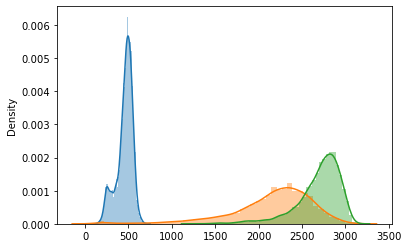

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

for k, complexity in enumerate(complexity_for_arplot):
#     sns.displot(complexity_for_arplot[k], kind='kde', fill=True, palette=sns.color_palette('bright')[k:k+1], rug=True)
    sns.distplot(complexity_for_arplot[k])

# Show the plot
plt.show()

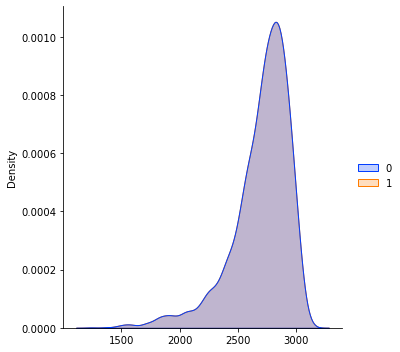